In [1]:
import numpy as np
import pandas as pd
import random
import math
import os
import scipy.io
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
# import torchvision
%matplotlib inline

from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from myfun.try_gpu import *
from myfun.setup_seed import *
from myfun.create_dataset import *
from myfun.evaluation import *
from model.cnn import CNN

np.set_printoptions(threshold=np.inf)

In [2]:
data = pd.read_csv('dataset/B0005.csv')
ts = data['Capacity'].tolist()
Cy = data['Cycles'].tolist()

In [3]:
dataX, dataY = create_dataset(ts, look_back=16)


In [3]:
def train(look_back=16, lr=0.001, EPOCH=1000, seed=0, train_size=15):
    dataX, dataY = create_dataset(ts, look_back)

    test_size = len(dataX) - train_size
    train_x = torch.from_numpy(dataX[:train_size])
    train_y = torch.from_numpy(dataY[:train_size])
    test_x = torch.from_numpy(dataX[train_size:])
    test_y = torch.from_numpy(dataY[train_size:])
    print(train_x.shape)

    setup_seed(seed)
    model = CNN()
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0)
    criterion = nn.MSELoss()

    score_list = []
    t_x = test_x.clone()
    loss_list = [0]
    mae, mse, rmse, r2 = 1, 1, 1, 1
    score_, score = 1,1
    for epoch in range(EPOCH):
        model.train()
        train_x = train_x.to(torch.float32).to(device)
        train_y = train_y.to(torch.float32).reshape(train_size, -1).to(device)
    
        out = model(train_x)
        loss = criterion(out, train_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (epoch + 1)%100 == 0:     #每100次重新预测一次
            model.eval()
            with torch.no_grad():
                t_x = test_x.clone()   
                t_x = t_x.to(torch.float32).to(device)
                pred_test = model(t_x) # 测试集的预测结果
                pred_test = pred_test.view(-1).cpu().detach().numpy()
            loss_list.append(loss)
            mae, mse, rmse, r2 = evaluation(test_y=test_y, pred_test=pred_test)

            print('epoch:{:<2d} | loss:{:<6.4f} | MAE:{:<6.4f} | MSE:{:<6.4f} | RMSE:{:<6.4f} | R2:{:<6.3f}'.format(epoch+1, loss, mae, mse, rmse, r2))
        
        score = [mae, mse, rmse, r2]
        # if (loss < 1e-3) and (score_[0] < score[0]) and (score_[2] < score[2]):
        #     break
        score_ = score.copy()
    score_list.append(score_)
    return score_list, pred_test

# 模型训练

## 30

In [4]:
look_back=16
lr=0.001
EPOCH=200
seed=0
train_size=15
device = try_gpu(10)
print("train on:",try_gpu(10))
score_list, pred_test = train(look_back=look_back, 
                                lr=lr, EPOCH=EPOCH, seed=seed, train_size=train_size)

train on: cpu
torch.Size([15, 1, 16])
epoch:100 | loss:0.0003 | MAE:0.0843 | MSE:0.0079 | RMSE:0.0886 | R2:0.705 
epoch:200 | loss:0.0003 | MAE:0.0802 | MSE:0.0072 | RMSE:0.0848 | R2:0.730 


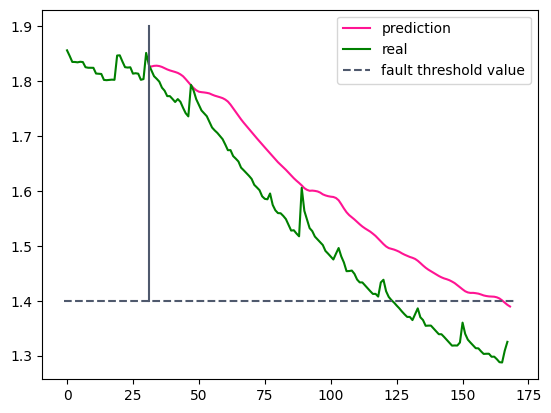

In [9]:
plt.plot(Cy[train_size+look_back:],pred_test, 'deeppink', label='prediction')
plt.plot(ts, 'green', label='real')
plt.plot([train_size+look_back,train_size+look_back],[1.4, 1.9], c='#4f596d', lw=1.5)
plt.plot([-1,170],[1.4, 1.4], c='#4f596d', lw=1.5, ls='--', label = 'fault threshold value')
plt.legend(loc='best')

In [11]:
txt = pred_test.tolist()
txt

[1.8271135091781616,
 1.8282054662704468,
 1.828519344329834,
 1.8278043270111084,
 1.826231837272644,
 1.8239507675170898,
 1.821700096130371,
 1.8198988437652588,
 1.8184715509414673,
 1.8170346021652222,
 1.8153377771377563,
 1.8127259016036987,
 1.8092378377914429,
 1.8040608167648315,
 1.7984068393707275,
 1.7928370237350464,
 1.787719488143921,
 1.7837367057800293,
 1.7810758352279663,
 1.7802573442459106,
 1.7797365188598633,
 1.7790043354034424,
 1.7779244184494019,
 1.77577543258667,
 1.7738860845565796,
 1.7725287675857544,
 1.7710058689117432,
 1.7693676948547363,
 1.7667860984802246,
 1.763156533241272,
 1.7575424909591675,
 1.75080406665802,
 1.7438563108444214,
 1.737119197845459,
 1.7306569814682007,
 1.7245632410049438,
 1.7188130617141724,
 1.7130049467086792,
 1.7073380947113037,
 1.7017396688461304,
 1.6960349082946777,
 1.690625548362732,
 1.685193419456482,
 1.67954421043396,
 1.6740764379501343,
 1.6685645580291748,
 1.6630305051803589,
 1.6576381921768188,
 1.652

## 60

In [14]:

look_back=16
lr=0.001
EPOCH=1500
seed=0
train_size=45
device = try_gpu(1)
print("train on:",try_gpu(1))
score_list, pred_test = train(look_back=look_back, 
                                lr=lr, EPOCH=EPOCH, seed=seed, train_size=train_size)

train on: cuda:1
torch.Size([45, 1, 16])
epoch:100 | loss:0.0008 | MAE:0.0615 | MSE:0.0040 | RMSE:0.0632 | R2:0.683 
epoch:200 | loss:0.0008 | MAE:0.0641 | MSE:0.0043 | RMSE:0.0657 | R2:0.658 
epoch:300 | loss:0.0008 | MAE:0.0619 | MSE:0.0040 | RMSE:0.0634 | R2:0.681 
epoch:400 | loss:0.0008 | MAE:0.0591 | MSE:0.0037 | RMSE:0.0606 | R2:0.709 
epoch:500 | loss:0.0008 | MAE:0.0560 | MSE:0.0033 | RMSE:0.0574 | R2:0.738 
epoch:600 | loss:0.0007 | MAE:0.0524 | MSE:0.0029 | RMSE:0.0539 | R2:0.770 
epoch:700 | loss:0.0007 | MAE:0.0485 | MSE:0.0025 | RMSE:0.0500 | R2:0.802 
epoch:800 | loss:0.0007 | MAE:0.0443 | MSE:0.0021 | RMSE:0.0459 | R2:0.833 
epoch:900 | loss:0.0007 | MAE:0.0399 | MSE:0.0017 | RMSE:0.0415 | R2:0.863 
epoch:1000 | loss:0.0007 | MAE:0.0352 | MSE:0.0014 | RMSE:0.0369 | R2:0.892 
epoch:1100 | loss:0.0007 | MAE:0.0305 | MSE:0.0011 | RMSE:0.0324 | R2:0.917 
epoch:1200 | loss:0.0006 | MAE:0.0258 | MSE:0.0008 | RMSE:0.0281 | R2:0.937 
epoch:1300 | loss:0.0006 | MAE:0.0212 | MSE:

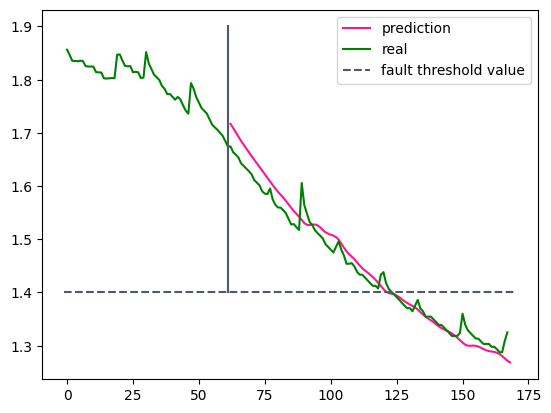

In [15]:
plt.plot(Cy[train_size+look_back:],pred_test, 'deeppink', label='prediction')
plt.plot(ts, 'green', label='real')
plt.plot([train_size+look_back,train_size+look_back],[1.4, 1.9], c='#4f596d', lw=1.5)
plt.plot([-1,170],[1.4, 1.4], c='#4f596d', lw=1.5, ls='--', label = 'fault threshold value')
plt.legend(loc='best')

In [16]:
txt = pred_test.tolist()
txt

[1.7168784141540527,
 1.7092535495758057,
 1.7011164426803589,
 1.6929137706756592,
 1.684997320175171,
 1.6775791645050049,
 1.6705188751220703,
 1.6634443998336792,
 1.6564538478851318,
 1.6494770050048828,
 1.6425812244415283,
 1.6359682083129883,
 1.6292312145233154,
 1.6223044395446777,
 1.615532398223877,
 1.6087830066680908,
 1.601951003074646,
 1.5953369140625,
 1.589253544807434,
 1.5838003158569336,
 1.578214168548584,
 1.5722490549087524,
 1.5657379627227783,
 1.5593018531799316,
 1.553209900856018,
 1.5477371215820312,
 1.542402982711792,
 1.5365874767303467,
 1.530261516571045,
 1.5273147821426392,
 1.5264791250228882,
 1.5276193618774414,
 1.5278425216674805,
 1.5261938571929932,
 1.5225062370300293,
 1.5175495147705078,
 1.5133056640625,
 1.51069176197052,
 1.5084797143936157,
 1.507069706916809,
 1.5041619539260864,
 1.4994224309921265,
 1.4918744564056396,
 1.4842115640640259,
 1.4773138761520386,
 1.471843957901001,
 1.4672367572784424,
 1.4624069929122925,
 1.4563753

## 90

In [18]:
look_back=16
lr=0.001
EPOCH=500
seed=0
train_size=75
device = try_gpu(1)
print("train on:",try_gpu(1))
score_list, pred_test = train(look_back=look_back, 
                                lr=lr, EPOCH=EPOCH, seed=seed, train_size=train_size)

train on: cuda:1
torch.Size([75, 1, 16])
epoch:100 | loss:0.0013 | MAE:0.0442 | MSE:0.0021 | RMSE:0.0462 | R2:0.574 
epoch:200 | loss:0.0012 | MAE:0.0401 | MSE:0.0018 | RMSE:0.0422 | R2:0.645 
epoch:300 | loss:0.0010 | MAE:0.0302 | MSE:0.0010 | RMSE:0.0320 | R2:0.795 
epoch:400 | loss:0.0009 | MAE:0.0203 | MSE:0.0005 | RMSE:0.0221 | R2:0.902 
epoch:500 | loss:0.0008 | MAE:0.0125 | MSE:0.0002 | RMSE:0.0157 | R2:0.951 


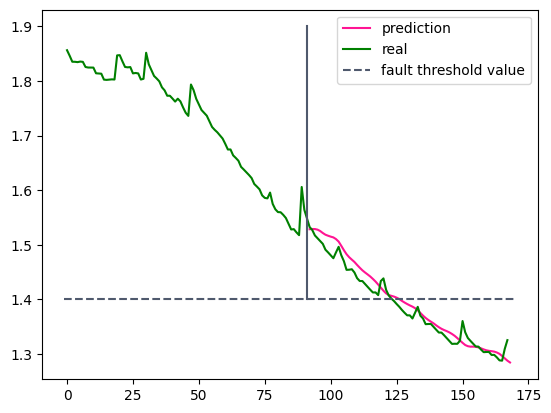

In [19]:
plt.plot(Cy[train_size+look_back:],pred_test, 'deeppink', label='prediction')
plt.plot(ts, 'green', label='real')
plt.plot([train_size+look_back,train_size+look_back],[1.4, 1.9], c='#4f596d', lw=1.5)
plt.plot([-1,170],[1.4, 1.4], c='#4f596d', lw=1.5, ls='--', label = 'fault threshold value')
plt.legend(loc='best')

In [20]:
txt = pred_test.tolist()
txt

[1.5283242464065552,
 1.5287764072418213,
 1.5287002325057983,
 1.5275942087173462,
 1.525076985359192,
 1.5214028358459473,
 1.518306851387024,
 1.5164414644241333,
 1.5147758722305298,
 1.5133824348449707,
 1.510318636894226,
 1.505696177482605,
 1.4979840517044067,
 1.4899226427078247,
 1.4826016426086426,
 1.4770667552947998,
 1.4726487398147583,
 1.4683133363723755,
 1.4629513025283813,
 1.4578622579574585,
 1.453100562095642,
 1.4491101503372192,
 1.4454723596572876,
 1.4416759014129639,
 1.4372221231460571,
 1.4324418306350708,
 1.4269529581069946,
 1.421309232711792,
 1.4156438112258911,
 1.410784363746643,
 1.4077376127243042,
 1.4062820672988892,
 1.4048789739608765,
 1.4029139280319214,
 1.4003738164901733,
 1.3970156908035278,
 1.3939993381500244,
 1.391248345375061,
 1.3887434005737305,
 1.3864763975143433,
 1.3836582899093628,
 1.3797787427902222,
 1.3749089241027832,
 1.3700367212295532,
 1.3657166957855225,
 1.3620587587356567,
 1.3589142560958862,
 1.3558464050292969,


# chen cnn

In [ ]:
def evaluate_loss(net,train_iter,loss,device = None):
    if device == None:
        device = d2l.try_gpu()
    net.to(device)
    metric = d2l.Accumulator(2)
    for X,y in train_iter:
        X, y = X.to(device), y.to(device)
        y_hat = net(X)
        l = loss(y_hat, y.long())
        metric.add(l.detach(),y.shape[0])
    return metric[0]/metric[1]

In [ ]:
def train_CNN(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)"""
    def init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(),lr=lr,)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch',ylabel='loss',
                            legend=['train_loss',"test_loss"],ylim=[0,0.25])
    animator1 = d2l.Animator(xlabel='epoch',ylabel='acc',legend=['train_acc','test_acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    epoch_list = []
    train_loss ,test_loss = [],[]
    train_acc  ,test_acc   = [],[]
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        net.train()
        for i,(X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y.long())
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                epoch_list.append(epoch + (i + 1) / num_batches)
                train_loss.append(evaluate_loss(net,train_iter,loss,device=device))
                test_loss.append(evaluate_loss(net,test_iter,loss,device=device))
                train_acc.append(d2l.evaluate_accuracy_gpu(net,train_iter))
                test_acc.append(d2l.evaluate_accuracy_gpu(net,test_iter))

                animator.add(epoch + (i + 1) / num_batches,
                             (train_loss[-1],test_loss[-1]))
                animator1.add(epoch + (i + 1) / num_batches, ( train_acc[-1], test_acc[-1]))
    return epoch_list,train_loss,test_loss,train_acc,test_acc

In [ ]:
ts = data['Capacity'].tolist()
dataX, dataY = create_dataset(ts, look_back=16)

